In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMAGE_SHAPE = (88, 200, 3)
CONTROLS_SHAPE = (4,)
COOR_SHAPE = (20,)
ENV_CTRL_SHAPE = ()

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 64

small-vgg

In [ ]:
# 0 - no dropout & no bn
# 1 - bn before activation layer + dropout after maxpool
# 2 - bn after each layer's activation + dropout after maxpool
# 3 - bn before maxpool + dropout after maxpool
# 4 - only dropout

def conv2d_block(x, n_layer=2, n_channel=16, kernel=(3,3), t=1):
    for i in range(n_layer):
        x = tf.keras.layers.Conv2D(n_channel, kernel, padding='same')(x)
        if t == 1:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        if t == 2:
            x = tf.keras.layers.BatchNormalization()(x)
    if t == 3:
        x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    if t != 0:
        x = tf.keras.layers.Dropout(0.5)(x)
    return x

In [ ]:
# 0 - no dropout
# 1 - dropout after activation layer

def fc_block(x, size, t=1):
    x = tf.keras.layers.Dense(size)(x)
    x = tf.keras.layers.Activation('relu')(x)
    if t != 0:
        x = tf.keras.layers.Dropout(0.2)(x)
    return x

In [ ]:
input_img = tf.keras.Input(shape=IMAGE_SHAPE)

img_stack = conv2d_block(input_img, 2, 16, (3,3), t=1)
img_stack = conv2d_block(img_stack, 2, 32, (3,3), t=1)
img_stack = conv2d_block(img_stack, 2, 64, (3,3), t=1)
img_stack = conv2d_block(img_stack, 2, 128, (3,3), t=1)

img_stack = tf.keras.layers.Flatten()(img_stack)
img_stack = tf.keras.layers.Dropout(0.2)(img_stack)

dense_img = fc_block(img_stack, 1024)
dense_img = fc_block(dense_img, 512)

######################################
input_pts = tf.keras.Input(shape=COOR_SHAPE)
dense_pts = fc_block(input_pts, 32)
dense_pts = fc_block(dense_pts, 32)

######################################
input_ctrl = tf.keras.Input(shape=CONTROLS_SHAPE)
dense_ctrl = fc_block(input_ctrl, 8)
dense_ctrl = fc_block(dense_ctrl, 16)


merged = tf.keras.layers.concatenate([dense_img, dense_ctrl, dense_pts])

# Add a few dense layers to finish the model
merged = fc_block(merged, 200)
merged = fc_block(merged, 64)
merged = tf.keras.layers.Dense(20, name='output')(merged)
### sigmoid layer

adam = tf.keras.optimizers.Nadam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model4 = tf.keras.Model(inputs=[input_img, input_ctrl, input_pts], outputs=merged)
model4.compile(optimizer=adam, loss='mse')

## ResNet 34

In [ ]:
class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            tf.keras.layers.Conv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            tf.keras.layers.Conv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                tf.keras.layers.Conv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
inputs = tf.keras.Input(IMAGE_SHAPE)
resnet34_out = tf.keras.layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
resnet34_out = tf.keras.layers.BatchNormalization()(resnet34_out)
resnet34_out = tf.keras.layers.Activation("relu")(resnet34_out)
resnet34_out = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")(resnet34_out)

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resnet34_out = ResidualUnit(filters, strides=strides)(resnet34_out)
    prev_filters = filters

resnet34_out = tf.keras.layers.GlobalAvgPool2D()(resnet34_out)
resnet34_out = tf.keras.layers.Flatten()(resnet34_out)
resnet34_out = tf.keras.layers.Dense(512, activation="relu")(resnet34_out)

resnet34_model = tf.keras.Model(inputs, resnet34_out, name="resnet34")
resnet34_model.summary()

## ResNet 50

In [ ]:
resnet50 = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=IMAGE_SHAPE,
)

In [ ]:
resnet50.summary()

## Translator

## Train

In [ ]:
!cp -r /content/drive/Shareddrives/Sam/Datasets/Carla/CarlaDS ./

In [ ]:
class Datasets:
    def __init__(self, path, test_potion=0.1):
        self.folders = [os.path.join(path, f) for f in os.listdir(path)]
        self.size = len(self.folders)
        self.test_potion = test_potion

    def __iter__(self):
        self.idx = 0
        return self

    def normalize_fn(control, controls_label, coordinate, env_control, image, wp):
        image = tf.cast(image, tf.float32) / 255.
        coordinate = coordinate / 20.0
        wp = wp / 20.0
        coordinate = tf.reshape(coordinate, [-1])
        wp = tf.reshape(wp, [-1])
        return control, controls_label, coordinate, env_control, image, wp

    def __next__(self):
        if self.idx < self.size:            
            controls = np.load(os.path.join(self.folders[self.idx], "controls.npy"))
            controls_labels = np.load(os.path.join(self.folders[self.idx], "controls_labels.npy"))
            coordinates = np.load(os.path.join(self.folders[self.idx], "coordinates.npy"))
            env_controls = np.load(os.path.join(self.folders[self.idx], "env_controls.npy"))
            images = np.load(os.path.join(self.folders[self.idx], "images.npy"))
            wps = np.load(os.path.join(self.folders[self.idx], "wps.npy"))

            l = controls.shape[0]
            mask = np.ones((l,), dtype=bool)
            indx = np.random.choice(l, int(l * self.test_potion))
            mask[indx] = False

            train_dataset = tf.data.Dataset.from_tensor_slices((
                controls[mask], controls_labels[mask], 
                coordinates[mask], env_controls[mask], 
                images[mask], wps[mask]))\
                .map(Datasets.normalize_fn)\
                .shuffle(SHUFFLE_BUFFER_SIZE)\
                .batch(BATCH_SIZE)

            test_dataset = tf.data.Dataset.from_tensor_slices((
                controls[~mask], controls_labels[~mask], 
                coordinates[~mask], env_controls[~mask], 
                images[~mask], wps[~mask]))\
                .map(Datasets.normalize_fn)\
                .shuffle(SHUFFLE_BUFFER_SIZE)\
                .batch(BATCH_SIZE)

            self.idx += 1
            return train_dataset, test_dataset
        else:
            raise StopIteration

In [ ]:
dss = Datasets("./CarlaDS")

In [ ]:
for train, test in dss:
    for control, controls_label, coordinate, env_control, image, wp in train:
        print(coordinate.shape)
        break

(64, 20)
(64, 20)


### Improvements 

* Next Coordinate as labels

In [ ]:
epochs = 100
ds_dir = './CarlaDS'
train_loss_values = np.zeros((epochs,))
test_loss_values = np.zeros((epochs,))

dss = Datasets(ds_dir)

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    loss = 0
    for train, test in dss:
        for step, (control, controls_label, coordinate, env_control, image, wp) in enumerate(train):
            loss = model4.train_on_batch([image, control, wp], coordinate)
            train_loss_values[epoch] += loss

        for step, (control, controls_label, coordinate, env_control, image, wp) in enumerate(test):
            loss = model4.test_on_batch([image, control, wp], coordinate)
            test_loss_values[epoch] += loss

    if epoch % 5 == 4:
        model4.save('./saved_model/model-' + str(epoch) + ".h5")
    print("\nTrainLoss: %f, TestLoss: %f" % (train_loss_values[epoch], test_loss_values[epoch]))


Start of epoch 0

TrainLoss: 0.049528, TestLoss: 0.037197

Start of epoch 1

TrainLoss: 0.048028, TestLoss: 0.040303

Start of epoch 2

TrainLoss: 0.049383, TestLoss: 0.038185

Start of epoch 3

TrainLoss: 0.048941, TestLoss: 0.037427

Start of epoch 4

TrainLoss: 0.046329, TestLoss: 0.038568

Start of epoch 5

TrainLoss: 0.046681, TestLoss: 0.041599

Start of epoch 6

TrainLoss: 0.048622, TestLoss: 0.039708

Start of epoch 7

TrainLoss: 0.046589, TestLoss: 0.034638

Start of epoch 8

TrainLoss: 0.047020, TestLoss: 0.040595

Start of epoch 9

TrainLoss: 0.047147, TestLoss: 0.037945

Start of epoch 10

TrainLoss: 0.043318, TestLoss: 0.035547

Start of epoch 11

TrainLoss: 0.046351, TestLoss: 0.038594

Start of epoch 12

TrainLoss: 0.044955, TestLoss: 0.044820

Start of epoch 13

TrainLoss: 0.044176, TestLoss: 0.045808

Start of epoch 14

TrainLoss: 0.042802, TestLoss: 0.041740

Start of epoch 15

TrainLoss: 0.046783, TestLoss: 0.036300

Start of epoch 16

TrainLoss: 0.042896, TestLoss:

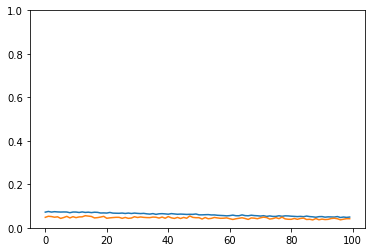

In [ ]:
plt.plot(train_loss_values)
plt.plot(test_loss_values)
plt.ylim(0, 1)
plt.show()

In [ ]:
!cp -r ./saved_model /content/drive/Shareddrives/Sam/

In [ ]:
!cp -r /content/drive/Shareddrives/Sam/saved_model ./

In [ ]:
model4_test = tf.keras.models.load_model('./saved_model/model-94')

tf.Tensor(0.6783243662442776, shape=(), dtype=float64)


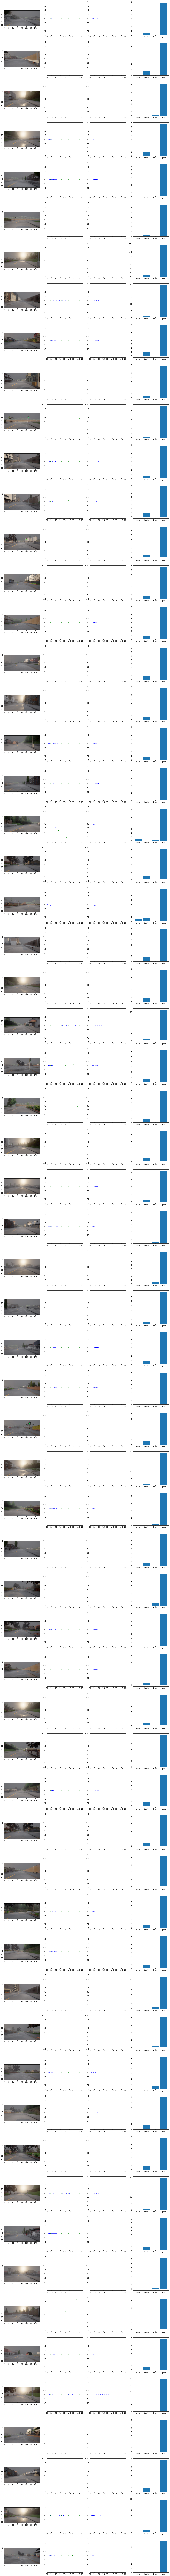

In [ ]:
l = 64
fields = ['steer', 'throttle', 'brake', 'speed']

_, test = next(iter(dss))
test_iter = iter(test)
control, controls_label, coordinate, env_control, image, wp = next(test_iter)
res = model4.predict([image, control, wp])
out = 20 * (res - coordinate)
print(tf.reduce_mean(out*out))

fig, axes = plt.subplots(l, 4, figsize=(20, l * 5))
for i, ((img_ax, ax2, ax_res, ax3), img, ctrl, w, coor, r) in enumerate(zip(axes, image, control, wp, coordinate, res)):

    coor = 20 * coor
    w = 20 * w
    r = 20 * r

    img_ax.imshow(img)

    ax2.scatter(coor[0::2], coor[1::2], s=2, color='b')
    ax2.scatter(w[0::2], w[1::2], s=2, color='green')
    ax2.scatter(coor[0], coor[1], s=2, color='r')
    ax2.set_xlim([0, 20])
    ax2.set_ylim([10,-10])

    ax_res.scatter(r[0::2], r[1::2], s=2, color='b')
    ax_res.set_xlim([0, 20])
    ax_res.set_ylim([10,-10])
    
    
    ax3.bar(fields, ctrl)
#     # ax3.set_ylim(-1, 1)